In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import shutup

In [3]:
shutup.please()

In [4]:
dailydata = pd.read_csv('../data/co2-ppm-daily_csv.csv')
problemdata = pd.read_csv('../data/ppm.csv')

In [5]:
year_lengths = []
j = 1991
dates = [dailydata.iloc[i][0] for i in range(len(dailydata))]
yeardates = [i for i in dates if i.split('-')[0] == str(j)]
year_data = dailydata.loc[dailydata['date'].isin(yeardates)]
print(j, len(year_data))
year_lengths.append((j, len(year_data)))

print(max(year_lengths, key=lambda x: x[1]))

1991 359
(1991, 359)


In [6]:
num_years = len(problemdata)

In [7]:
YEAR = str(1991)

x_daily, y_daily = list(map(lambda x: x/359, range(359))), list(year_data.value)
x_yearly, y_yearly = list(problemdata.Year), list(problemdata.PPM)

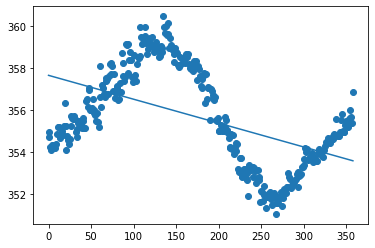

In [85]:
a, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, a*x+b)

def cos_func(times, amp, freq, y=355.6131):
    inside = freq*times
    middle = amp*np.cos(inside)

    return middle + y

(x[list(y).index(min(y))] - x[list(y).index(max(y))])*2

popt, pcov = curve_fit(
    cos_func,
    x, y,
    p0=((max(y)-min(y))/2, 2*np.pi/300)
)

plt.plot(x, y, '.', label='Measured')
plt.plot(x, cos_func(pd.Series(x), popt[0], popt[1]), label='Best Fit')
plt.plot(x, cos_func(pd.Series(x), (max(y)-min(y))/2, 2*np.pi/300))

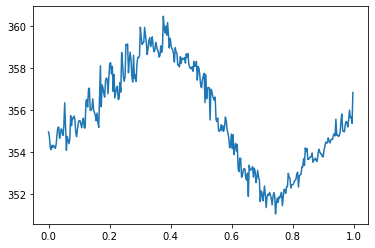

In [8]:
plt.plot(x_daily, y_daily)

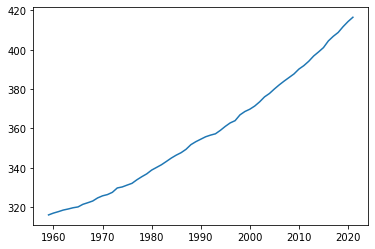

In [9]:
plt.plot(x_yearly, y_yearly)

In [10]:
base_slope = float((problemdata.iloc[32][1] - problemdata.iloc[33][1])/(1991-1992))

In [11]:
y_at_1991 = y_yearly[x_yearly.index(1991)]

In [12]:
def translate_by_starting_point(year, data):
    year_start = y_yearly[x_yearly.index(year)]
    difference = y_at_1991 - year_start
    new_data = []
    for i in data:
        new_data.append(i-difference)
    
    return new_data

def shift_with_slope(slope, data):
    new_data = []
    try:
        for ind, val in enumerate(data):
            difference = (slope-base_slope)*(ind/359)
            new_data.append(val + difference)
    except TypeError:
        print(ind)
    
    return new_data



# method doesn't work due to limitation of angle; angle cannot go beyond 90 degrees
def slope_with_respect_to_base(slope, base_slope):
    return np.math.tan(np.math.atan(slope) - np.math.atan(base_slope))

In [13]:
sum(year_data.iloc[i][1] for i in range(len(year_data))) / len(year_data)

355.61309192200554

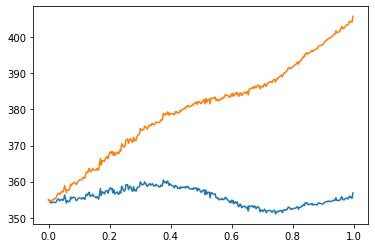

In [89]:
plt.plot(x_daily, y_daily)
# shifted_y_daily = []

plt.plot(x_daily, shift_with_slope(50, y_daily))
# plt.plot(x_yearly, y_yearly)

In [15]:
slope_with_respect_to_base(1, base_slope)

0.08695652173911154

In [16]:
interpol_data_y = pd.Series()

slopes = []

for ind, val in enumerate(x_yearly[:-1]):
    slope = y_yearly[ind+1] - y_yearly[ind]

    # slope_w_respect = slope_with_respect_to_base(slope, base_slope)

    # slopes.append(slope_w_respect)

    x_values = [i / 359 + val-1959 for i in range(359)]
    # new_data = pd.Series(y_daily) + [i*slope_w_respect for i in x_values] - sum(y_daily)/len(y_daily)
    new_data = shift_with_slope(slope, translate_by_starting_point(val, y_daily))
    interpol_data_y = interpol_data_y.append(pd.Series(new_data))


In [19]:
interpol_data_x = [i/359+1959 for i in range(359*62)]

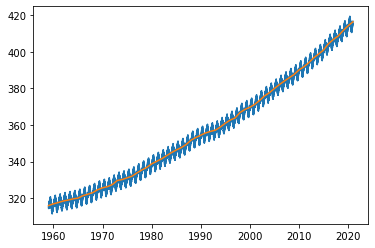

In [20]:
plt.plot(interpol_data_x, interpol_data_y)
plt.plot(x_yearly, y_yearly)

In [21]:
len(interpol_data_y)

22258

In [22]:
year_labels = []

for i in range(1959, 2021):
    year_labels += [j.replace('1991', str(i)) for j in yeardates]

In [23]:
len(interpol_data_y)

22258

In [24]:
interpol_data_dict = {'Date': year_labels, 'Year': interpol_data_x, 'PPM': interpol_data_y}

In [85]:
interpol_data = pd.DataFrame(interpol_data_dict)

In [87]:
interpol_data.to_csv('../data/interpolated_data.csv', index=False)